# Focus: Smoothness

In [1]:
import kagglehub
import pandas as pd # to work with dataframes, manipulate data (panel data)
import matplotlib.pyplot as plt # viz library
import seaborn as sns # HD viz library
import numpy as np # to work with numbers (numerical python)
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from scipy.stats import pearsonr

%matplotlib inline
pd.set_option('display.max_columns', None)

data = pd.read_csv(r'cleaned_data.csv')
df = data.copy()

c:\ProgramData\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Specifying only smoothness related columns

In [2]:
df_smooth = df[['id', 'diagnosis','smoothness_mean', 'smoothness_se', 'smoothness_worst' ]]

### Defining a new value column

Idea: Add a new value for the difference between mean smoothness and smoothness at worst to explore possible correlation focusing the change of size

In [3]:
# defining a new measure for the difference between the mean and the worst smoothes
df_smooth = df_smooth.assign( smoothness_diff = lambda x: (x['smoothness_worst'] - x['smoothness_mean'] ))
df_smooth

,id,diagnosis,smoothness_mean,smoothness_se,smoothness_worst,smoothness_diff
0,842302,M,0.11840,0.006399,0.16220,0.04380
1,842517,M,0.08474,0.005225,0.12380,0.03906
2,84300903,M,0.10960,0.006150,0.14440,0.03480
3,84348301,M,0.14250,0.009110,0.20980,0.06730
4,84358402,M,0.10030,0.011490,0.13740,0.03710
...,...,...,...,...,...,...
564,926424,M,0.11100,0.010300,0.14100,0.03000
565,926682,M,0.09780,0.005769,0.11660,0.01880
566,926954,M,0.08455,0.005903,0.11390,0.02935
567,927241,M,0.11780,0.006522,0.16500,0.04720


In [4]:
# filtering the DataFrame by diagnosis
df_M = df_smooth[df_smooth['diagnosis'] == 'M']
df_B = df_smooth[df_smooth['diagnosis'] == 'B']

In [5]:
# list of smoothness variables to compare
smoothness_vars = ['smoothness_mean', 'smoothness_se', 'smoothness_worst', 'smoothness_diff']

### Smoothness histograms and overview

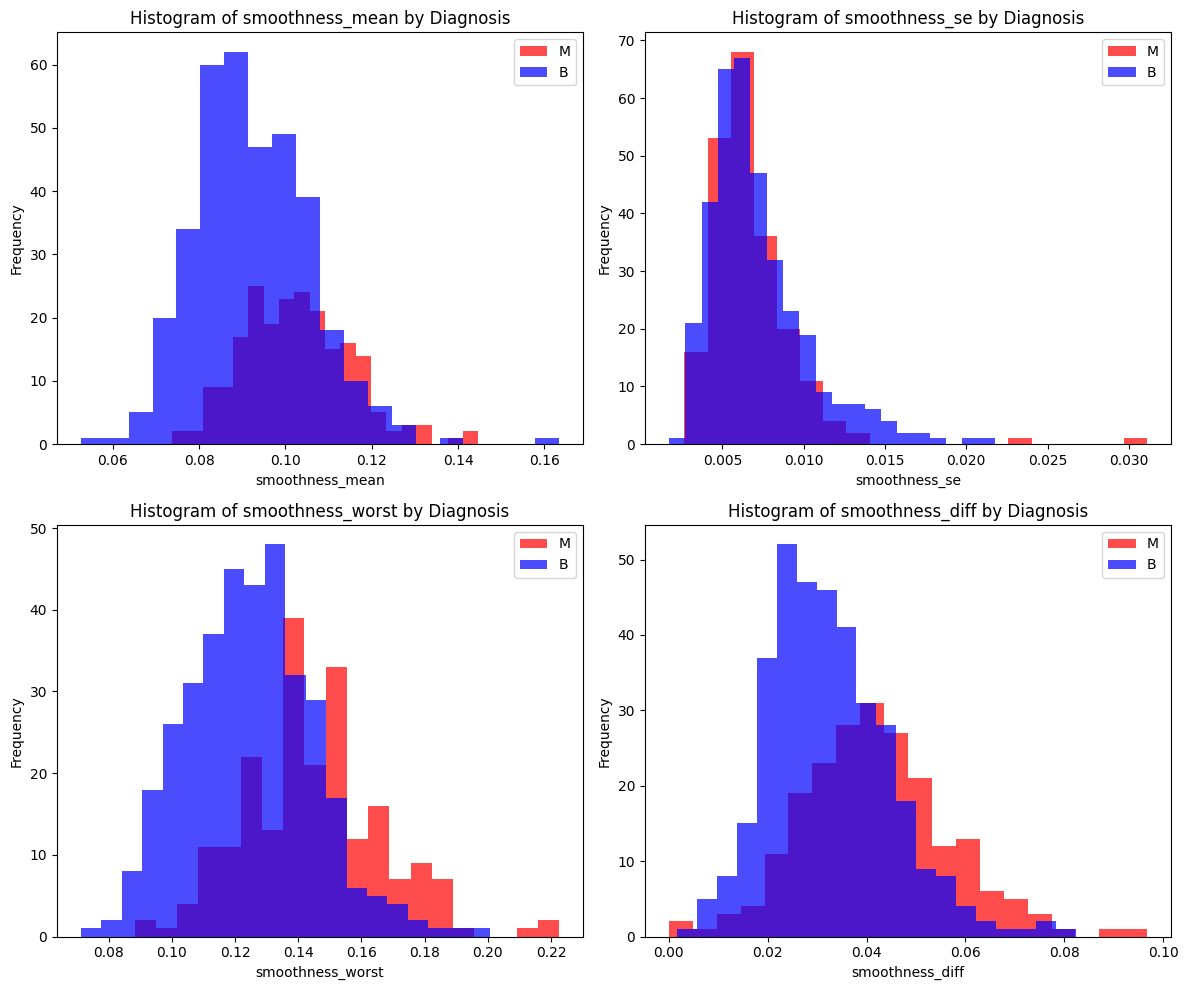

In [6]:
# 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# loop through each smoothness variable and plot overlapping histograms for "M" and "B"
for i, var in enumerate(smoothness_vars):
    ax = axes[i // 2, i % 2]
    # filtering data by diagnosis
    data_M = df_smooth[df_smooth['diagnosis'] == 'M'][var]
    data_B = df_smooth[df_smooth['diagnosis'] == 'B'][var]
    
    # plot overlapping histograms with same style and colors:
    # diagnosis M in red and diagnosis B in blue, with alpha=0.7
    ax.hist(data_M, bins=20, alpha=0.7, label='M', color='red')
    ax.hist(data_B, bins=20, alpha=0.7, label='B', color='blue')
    
    ax.set_title(f"Histogram of {var} by Diagnosis")
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.savefig('plots/histo_smoothness.png')
plt.show()


### Closer look at the overlapping regions

C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7852\3290952592.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df_overlap.groupby(var + '_bin')['diagnosis'].count()
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7852\3290952592.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_cancer = df_overlap.groupby(var + '_bin')['diagnosis'].apply(lambda x: (x == 'M').sum() / len(x))
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7852\3290952592.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

smoothness_mean_bin
(0.0727, 0.0808]    0.076923
(0.0808, 0.0879]    0.181818
(0.0879, 0.095]     0.396226
(0.095, 0.102]      0.396226
(0.102, 0.109]      0.483871
(0.109, 0.116]      0.620000
(0.116, 0.123]      0.760000
(0.123, 0.131]      0.454545
(0.131, 0.138]      0.750000
(0.138, 0.145]      1.000000
Name: diagnosis, dtype: float64
smoothness_se_bin
(0.00167, 0.00458]    0.314607
(0.00458, 0.00649]    0.449275
(0.00649, 0.0084]     0.374101
(0.0084, 0.0103]      0.333333
(0.0103, 0.0122]      0.344828
(0.0122, 0.0141]      0.200000
(0.0141, 0.016]       0.000000
(0.016, 0.0179]       0.000000
(0.0179, 0.0199]      0.000000
(0.0199, 0.0218]      0.000000
Name: diagnosis, dtype: float64
smoothness_worst_bin
(0.0872, 0.0995]    0.066667
(0.0995, 0.111]     0.125000
(0.111, 0.122]      0.223529
(0.122, 0.133]      0.288288
(0.133, 0.144]      0.420168
(0.144, 0.156]      0.589744
(0.156, 0.167]      0.694444
(0.167, 0.178]      0.666667
(0.178, 0.189]      0.933333
(0.189, 0.201]  

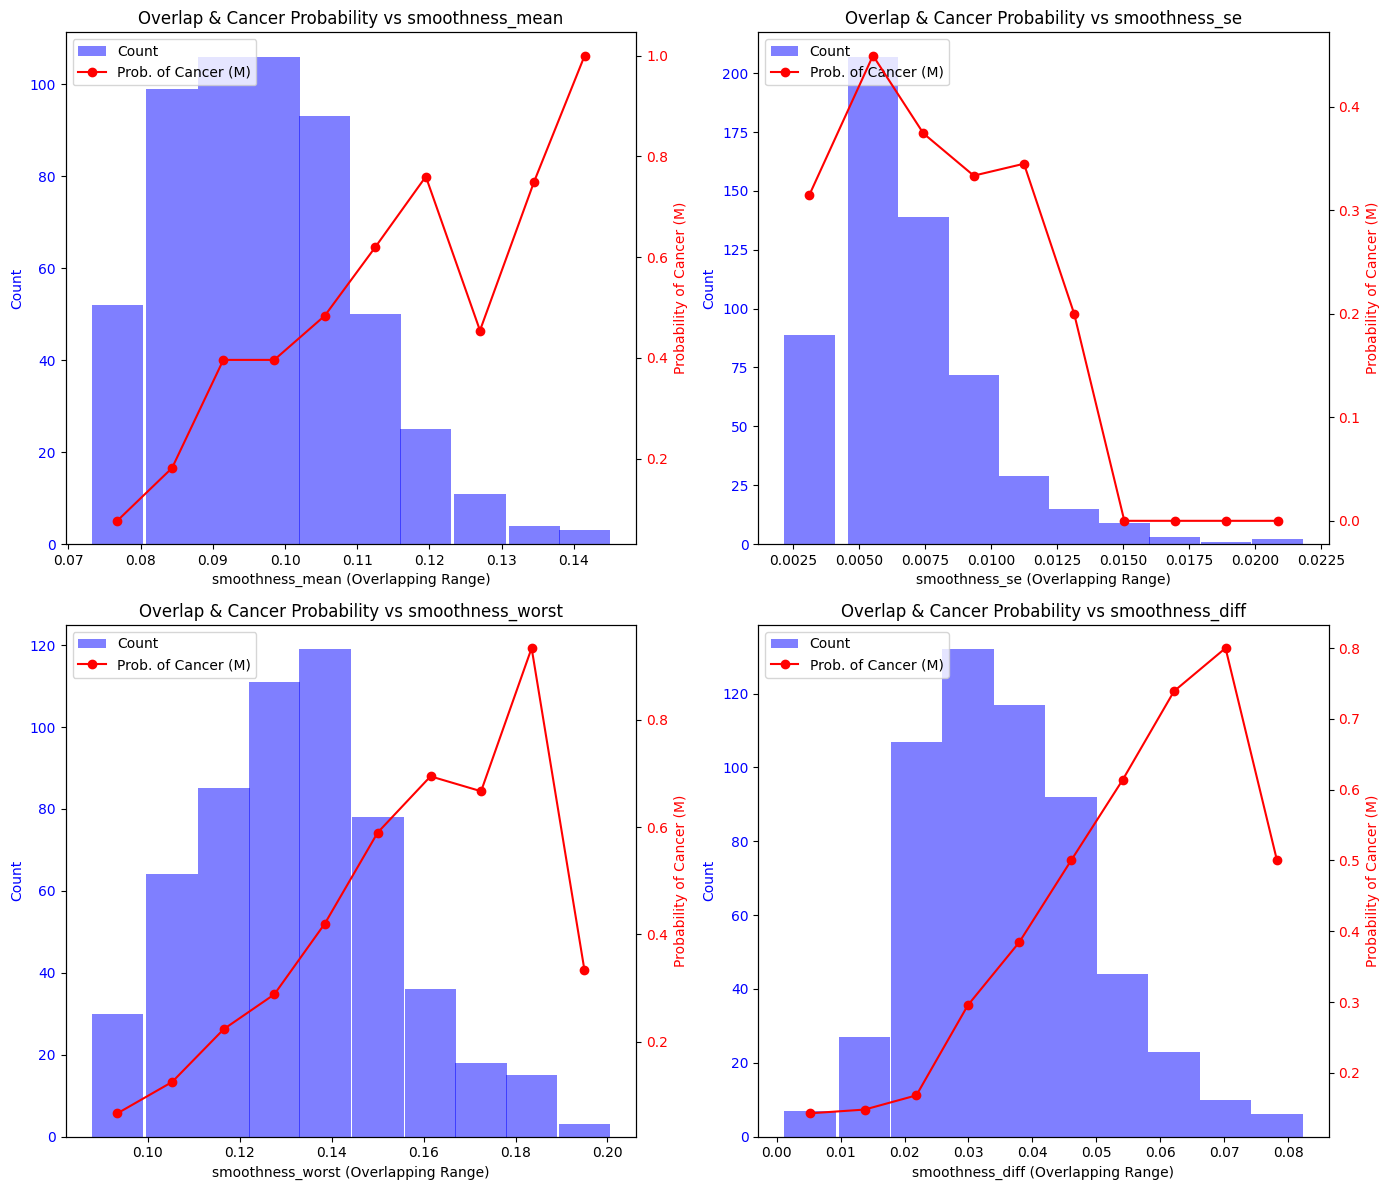

In [7]:
#  2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# loop over each smoothness variable
for i, var in enumerate(smoothness_vars):
    
    # determine the overlapping range for the variable
    min_overlap = max(df_M[var].min(), df_B[var].min())
    max_overlap = min(df_M[var].max(), df_B[var].max())
    
    # filter the DataFrame to the overlapping region
    df_overlap = df_smooth[(df_smooth[var] >= min_overlap) & (df_smooth[var] <= max_overlap)].copy()
    
    # create 10 evenly spaced bins in the overlapping range
    bins = np.linspace(min_overlap, max_overlap, 11)
    df_overlap[var + '_bin'] = pd.cut(df_overlap[var], bins=bins, include_lowest=True)
    
    # calculate counts for each bin and the probability of diagnosis "M"
    bin_counts = df_overlap.groupby(var + '_bin')['diagnosis'].count()
    prob_cancer = df_overlap.groupby(var + '_bin')['diagnosis'].apply(lambda x: (x == 'M').sum() / len(x))
    print(prob_cancer)

    # calculate bin centers and bin width
    bin_centers = [interval.mid for interval in bin_counts.index.categories]
    bin_width = bins[1] - bins[0]
    
    # plot on the current subplot
    ax = axes[i]
    # histogram (bar chart) for counts on primary y-axis (blue)
    ax.bar(bin_centers, bin_counts, width=bin_width, alpha=0.5, color='blue', label='Count')
    ax.set_xlabel(f"{var} (Overlapping Range)")
    ax.set_ylabel("Count", color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_title(f"Overlap & Cancer Probability vs {var}")
    
    # create a secondary y-axis for the probability curve (red)
    ax2 = ax.twinx()
    ax2.plot(bin_centers, prob_cancer.values, marker='o', linestyle='-', color='red', label='Prob. of Cancer (M)')
    ax2.set_ylabel("Probability of Cancer (M)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('plots/histo_overlap_smoothness.png')
plt.show()


### Boxplot overview of 4 smoothness metrics

C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7852\506698865.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_smooth,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7852\506698865.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_smooth,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7852\506698865.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_smooth,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_7852\506698865.py:8: FutureWarning: 

Passing `palet

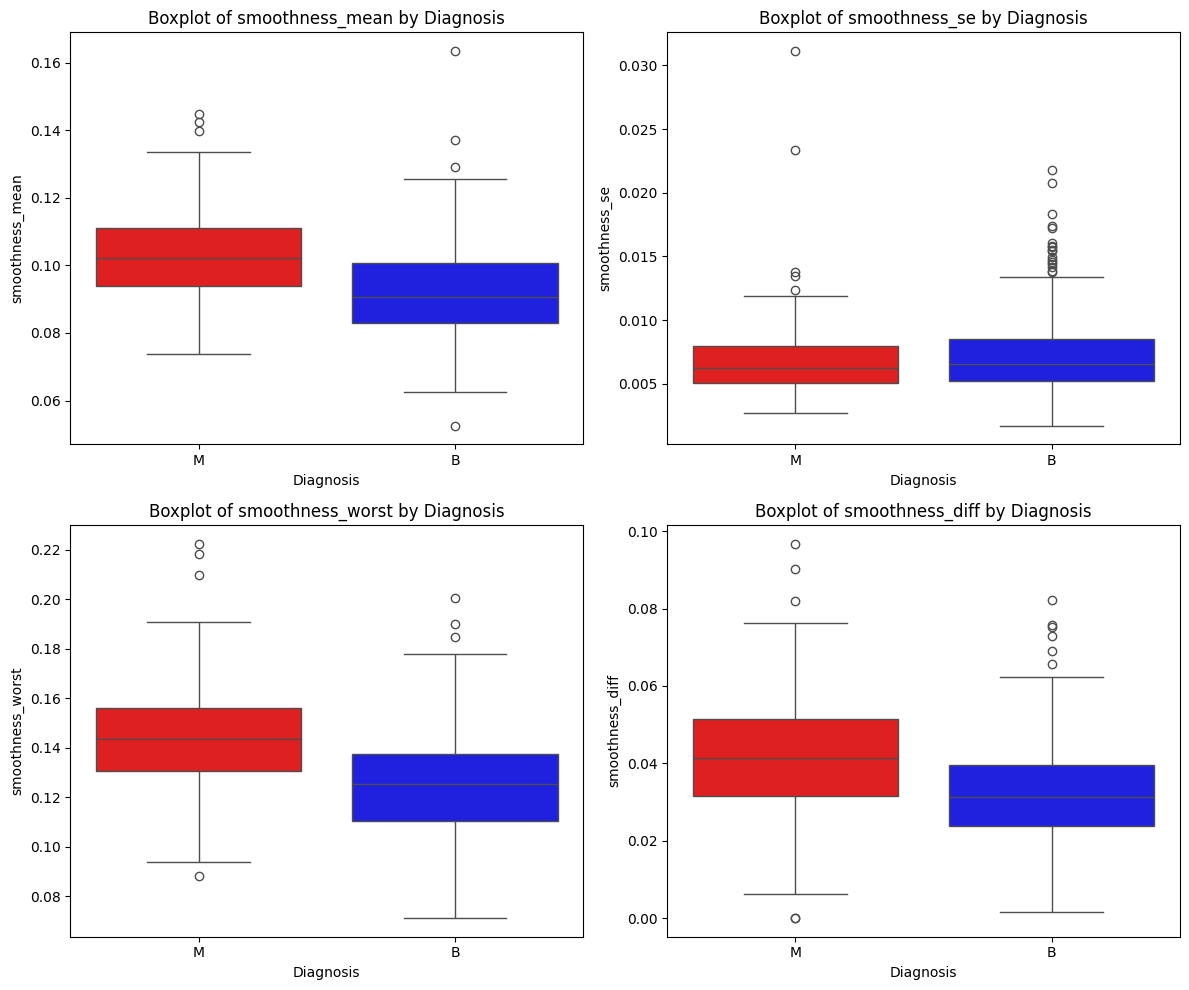

In [8]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # flatten the axes array so each element is an Axes instance

# Loop over each variable and generate a boxplot
for i, var in enumerate(smoothness_vars):
    ax = axes[i]
    sns.boxplot(x='diagnosis', y=var, data=df_smooth,
                palette={'M': 'red', 'B': 'blue'}, ax=ax)
    ax.set_title(f"Boxplot of {var} by Diagnosis")
    ax.set_xlabel("Diagnosis")
    ax.set_ylabel(var)

plt.tight_layout()
plt.savefig('plots/boxplt_smoothness.png')
plt.show()


### Pearson's correlation for smoothness_mean, smoothness_se, smoothness_worst and smoothnesss_diff with diagnosis

In [9]:
df_smooth['diagnosis_numeric'] = df_smooth['diagnosis'].map({'B': 0, 'M': 1})

# list of smoothness variables to analyze
smoothness_columns = ['smoothness_mean', 'smoothness_se', 'smoothness_worst', 'smoothness_diff']

# dictionary for correlation results
results = {}

for col in smoothness_columns:
    r, p = pearsonr(df_smooth['diagnosis_numeric'], df_smooth[col])
    results[col] = {'p-value': p, 'r-Pearson': r}

results_df = pd.DataFrame(results).T
print(results_df)


                       p-value  r-Pearson
smoothness_mean   1.051850e-18   0.358560
smoothness_se     1.102966e-01  -0.067016
smoothness_worst  6.575144e-26   0.421465
smoothness_diff   3.186910e-15   0.322335


smoothness mean and max(_worst) show the closest to 0 values, indicating strong correlation

### Chi-Square for the overlapping region for diagnosis and smoothness at worst

Let's pick the smoothness metric with the smallest p-value and calculate its Chi-Square p-value.

Since the smoothness is a continues numeric data, first converting it into discrete values within the overlapping region using binning technique and then calculating p-value of Chi-Square

In [10]:
# determining overlapping range
min_overlap = max(df_M['smoothness_worst'].min(), df_B['smoothness_worst'].min())
max_overlap = min(df_M['smoothness_worst'].max(), df_B['smoothness_worst'].max())

df_overlap = df_smooth[(df_smooth['smoothness_worst'] >= min_overlap) & (df_smooth['smoothness_worst'] <= max_overlap)]

# bins for the overlapping region (10 bins)
bins = np.linspace(min_overlap, max_overlap, 11)
df_overlap = df_overlap.copy()  # avoid SettingWithCopyWarning
df_overlap['smoothness_bin'] = pd.cut(df_overlap['smoothness_worst'], bins=bins, include_lowest=True)


contingency_table = pd.crosstab(df_overlap['smoothness_bin'], df_overlap['diagnosis'])
print(contingency_table)


_,pvalue, _, _ = chi2_contingency(contingency_table)
cramer_v = association(contingency_table, method='cramer')
print(f'Chi-Square p-value is {pvalue}\nCramer V is: {cramer_v}')


diagnosis          B   M
smoothness_bin          
(0.0872, 0.0995]  28   2
(0.0995, 0.111]   56   8
(0.111, 0.122]    66  19
(0.122, 0.133]    79  32
(0.133, 0.144]    69  50
(0.144, 0.156]    32  46
(0.156, 0.167]    11  25
(0.167, 0.178]     6  12
(0.178, 0.189]     1  14
(0.189, 0.201]     2   1
Chi-Square p-value is 1.7291450034893318e-17
Cramer V is: 0.4225264211058961


Although the chi-square test produced a statistically significant p-value, the corresponding Cramér's V value remained below 0.5. This suggests that the smoothness metric does not exhibit a strong correlation or association relative to the other metrics under evaluation.